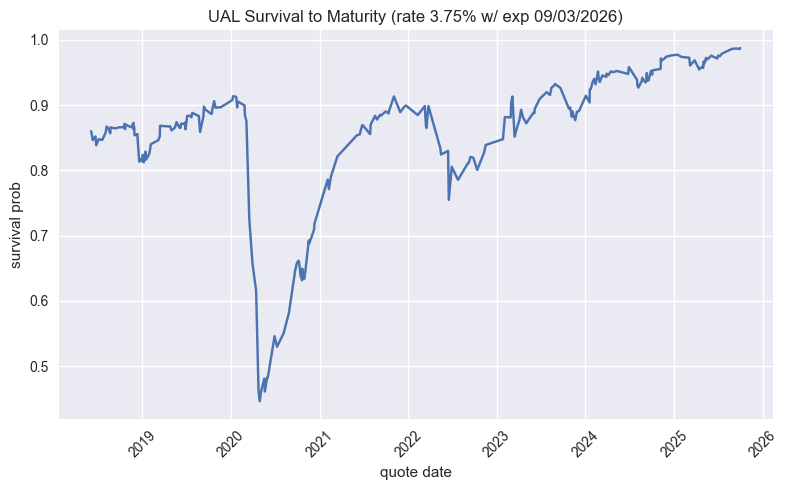


saved to /Users/anthonygiller/Downloads/UAL_reduced_form_survival.csv 

          date  last_value  spread_bps  spread_dec    hazard   tau_yrs  \
0   2018-06-04     109.617     109.617    0.010962  0.018270  8.254795   
1   2018-06-11     121.611     121.611    0.012161  0.020269  8.235616   
2   2018-06-22     117.185     117.185    0.011718  0.019531  8.205479   
3   2018-06-25     129.005     129.005    0.012900  0.021501  8.197260   
4   2018-07-05     121.420     121.420    0.012142  0.020237  8.169863   
5   2018-07-20     122.925     122.925    0.012292  0.020487  8.128767   
6   2018-08-03     113.665     113.665    0.011366  0.018944  8.090411   
7   2018-08-07     105.916     105.916    0.010592  0.017653  8.079452   
8   2018-08-16     110.066     110.066    0.011007  0.018344  8.054795   
9   2018-08-22     115.404     115.404    0.011540  0.019234  8.038356   
10  2018-08-23     107.574     107.574    0.010757  0.017929  8.035616   
11  2018-09-11     109.736     109.736 

In [25]:
#import libraries 

import pandas as pd, numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

#========================================

#loading csv 

file = r"C:\Users\LiamRodgers\Desktop\Python\Classes\FE800\FE800-Research\UAL_prices.csv"
df = pd.read_csv(file)


#keeping date to last in spread 

df = df.rename(columns={"Date":"date","Last":"last_value"}).loc[:,["date","last_value"]]

#========================================

#parse dates + numeric 

def dates(x):
    
    for fmt in ("%m/%d/%Y","%m/%d/%y","%Y-%m-%d"):
        
        try: return datetime.strptime(str(x), fmt).date()
        except: pass
    return pd.NaT


def tnum(x):
    
    s = str(x).replace(",", "").strip()
    
    try: return float(s)
    except: return np.nan
    

df["date"] = df["date"].apply(dates)
df["last_value"] = df["last_value"].apply(tnum)
df = df.dropna(subset=["date", "last_value"]).sort_values("date").reset_index(drop=True)

#========================================

#reduced form - spread, hzrd, survival probs 


df["spread_bps"] = df["last_value"]          
df["spread_dec"] = df["spread_bps"] / 1e4


#assuming recovery rate 

r = 0.4                                      
df["hazard"] = df["spread_dec"] / (1 - r)


#taking exp maturity from bond des

expm = datetime(2026, 9, 3).date()

df["tau_yrs"] = (pd.to_datetime(expm) - pd.to_datetime(df["date"])).dt.days / 365.0
df = df[df["tau_yrs"] >= 0].copy()


#calculating survival under constant hzrd to maturity 

df["s_tau"] = np.exp(-df["hazard"] * df["tau_yrs"])

#save as csv 

#saved = "/Users/anthonygiller/Downloads/UAL_reduced_form_survival.csv"
#df.to_csv("UAL_survival_to_maturity.csv", index=False)

#========================================

#plot survival prob 

plt.figure(figsize=(8,5))

plt.plot(df["date"], df["s_tau"])
plt.title("UAL Survival to Maturity (rate 3.75% w/ exp 09/03/2026)")
plt.xlabel("quote date") 
plt.ylabel("survival prob")

plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

#saved msg with file path and showing first 12 rows 

print(f"\nsaved to {saved} \n")
print(df.head(12))


In [26]:
df['date'] = pd.to_datetime(df['date'])
df['Time_to_Maturity'] = (pd.to_datetime(expm) - df['date']).dt.days / 365.0
df = df[['date', 'Time_to_Maturity', 'last_value', 'spread_bps', 'spread_dec', 'hazard', 'tau_yrs', 's_tau']]
df

,date,Time_to_Maturity,last_value,spread_bps,spread_dec,hazard,tau_yrs,s_tau
0,2018-06-04,8.254795,109.6170,109.6170,0.010962,0.018270,8.254795,0.860010
1,2018-06-11,8.235616,121.6110,121.6110,0.012161,0.020269,8.235616,0.846264
2,2018-06-22,8.205479,117.1850,117.1850,0.011718,0.019531,8.205479,0.851922
3,2018-06-25,8.197260,129.0050,129.0050,0.012900,0.021501,8.197260,0.838410
4,2018-07-05,8.169863,121.4200,121.4200,0.012142,0.020237,8.169863,0.847613
...,...,...,...,...,...,...,...,...
247,2025-08-28,1.016438,81.3715,81.3715,0.008137,0.013562,1.016438,0.986310
248,2025-09-18,0.958904,83.7145,83.7145,0.008371,0.013952,0.958904,0.986710
249,2025-09-23,0.945205,90.6029,90.6029,0.009060,0.015100,0.945205,0.985828
250,2025-09-29,0.928767,88.5849,88.5849,0.008858,0.014764,0.928767,0.986381


In [ ]:
#Fitting the hazard rate curve with exponential spline

import numpy as np
from scipy.optimize import curve_fit

def exp_spline(t, beta1, beta2, beta3, l1, l2, l3):
    return beta1 * np.exp(-l1 * t) + beta2 * np.exp(-l2 * t) + beta3 * np.exp(-l3 * t) #Equation for splining

# Initial guesses for β and λ, we can tune these if needed
p0 = [0.6, 0.3, 0.1, 0.2, 0.05, 0.01]

params, covariance = curve_fit(
    exp_spline, df['Time_to_Maturity'], df['s_tau'], p0=p0,
    bounds=(0, [1, 1, 1, 5, 1, 0.5]) # coefficients sum to 1, rates positive
)

beta1, beta2, beta3, l1, l2, l3 = params
print("Fitted parameters:", params)



Fitted parameters: [3.67128461e-01 3.95855323e-01 3.91544210e-01 4.62927011e-01
 3.90002185e-21 2.67611662e-21]


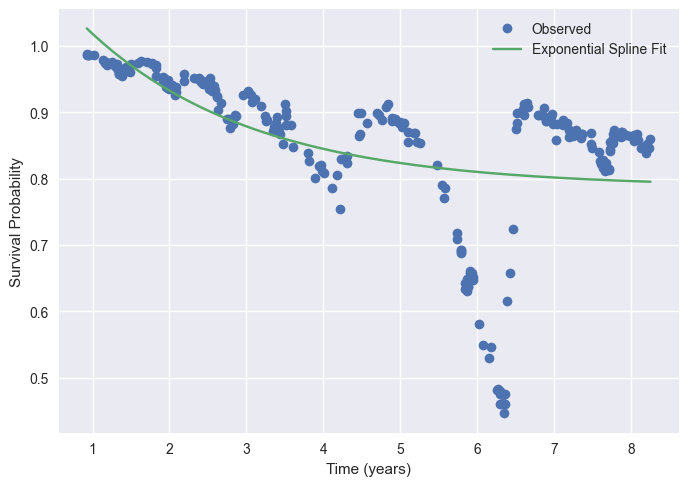

In [28]:
# Create fitted curve
df['Q_fit'] = exp_spline(df['Time_to_Maturity'], *params)

plt.plot(df['Time_to_Maturity'], df['s_tau'], 'o', label="Observed")
plt.plot(df['Time_to_Maturity'], df['Q_fit'], '-', label="Exponential Spline Fit")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()


**Next step is the price with the survival based framework**